In [2]:
from google.colab import files
uploaded = files.upload()

Saving resampled_abnormal.npy to resampled_abnormal.npy
Saving resampled_normal.npy to resampled_normal.npy


# 두 파일을 불러와서 X,y 데이터 생성

In [3]:
import numpy as np

# 리샘플링된 PPG 세그먼트 불러오기
X_normal = np.load('resampled_normal.npy')      # shape: (n_normal, 100)
X_abnormal = np.load('resampled_abnormal.npy')  # shape: (n_abnormal, 100)

# 라벨 생성
y_normal = np.zeros(len(X_normal), dtype=int)
y_abnormal = np.ones(len(X_abnormal), dtype=int)

# 결합
X = np.concatenate((X_normal, X_abnormal), axis=0)
y = np.concatenate((y_normal, y_abnormal), axis=0)

# 차원 추가: (샘플 수, 100, 1)
X = X.reshape(-1, 100, 1)

# 학습용 CNN 모델 구성

In [4]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import numpy as np

# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_idx, val_idx in kf.split(X, y):
    print(f"\n📂 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(100, 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0)

    # 평가
    y_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_val, y_pred)
    print(f"✅ Fold {fold} Accuracy: {acc:.4f}")
    accuracies.append(acc)
    fold += 1

print(f"\n📊 평균 정확도 (5-Fold): {np.mean(accuracies):.4f}")


📂 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Fold 1 Accuracy: 0.9867

📂 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ Fold 2 Accuracy: 0.9845

📂 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 3 Accuracy: 0.9874

📂 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Fold 4 Accuracy: 0.9823

📂 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ Fold 5 Accuracy: 0.9837

📊 평균 정확도 (5-Fold): 0.9849


# Confusion Matrix & 정밀도/재현율/F1 score 출력

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, y_pred, target_names=["Normal", "Arrhythmia"]))

              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       614
  Arrhythmia       0.99      0.98      0.99       739

    accuracy                           0.98      1353
   macro avg       0.98      0.98      0.98      1353
weighted avg       0.98      0.98      0.98      1353



# ROC Curve & AUC

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


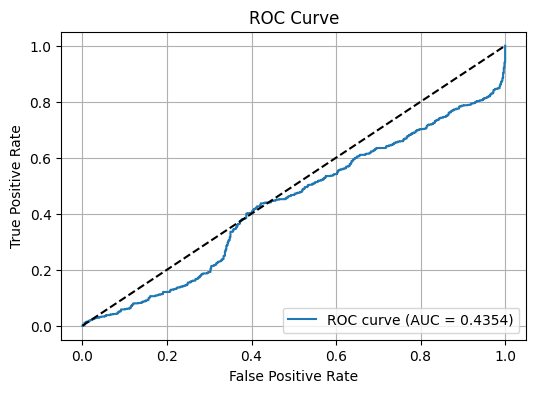

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(X_val).flatten()
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 모델 구조 시각화

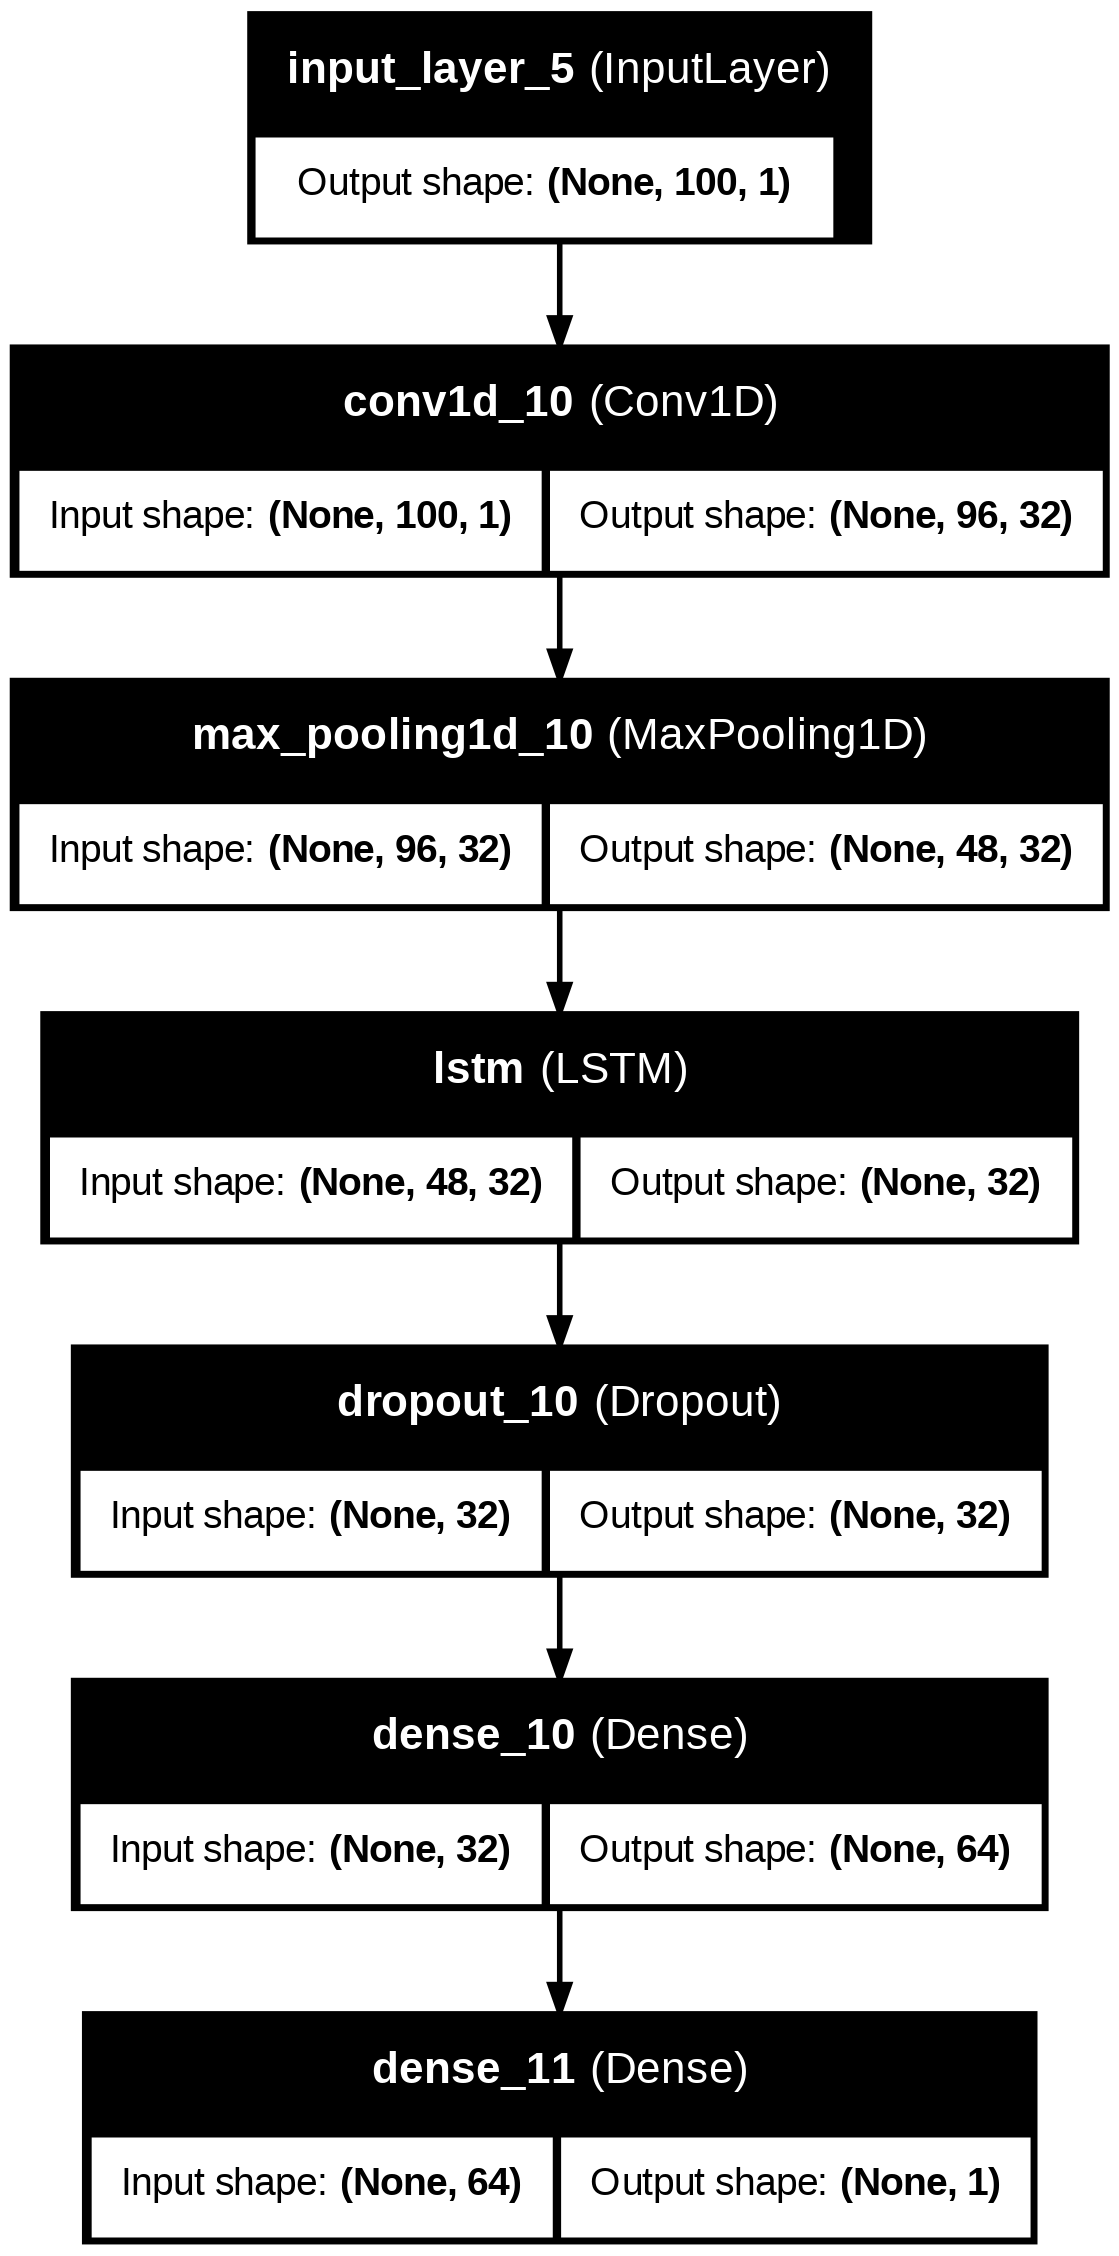

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)